# Two Sensor Experiments

Includes an upstream and a downstream sensor

## Import Statements

In [2]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import correlate

# UrbanSurge imports.
from urbansurge.swmm_model import SWMM
from urbansurge.data_acquisition import align_measurements, voltage_to_value, approx_dVdt
from urbansurge.data_acquisition import discrete_flow_series, flow_rate, flow_to_swmm_readable, mean_reading
from urbansurge.fault_diagnosis.moment_detection import moment_fault_detect

## Sensor Parameters

In [3]:
sensor_parameters = {
    'Sergei': {
        'calibration': {
            'b0': 0.1195,
            'b1': 0.7656
        },
        'location': 'pipe',
    },
    'Louise': {
        'calibration': {
            'b0': 0.3208,
            'b1': 0.7624
        },
        'location': 'pipe',
    },
    'Ludwig': {
        'calibration': {
            'b0': -0.1124,
            'b1': 0.7839
        },
        'location': 'pipe',
    },
    'Tank': {
        'calibration': {
            'b0': 4.3401,
            'b1': 2.3017
        },
        'location': 'tank',
    },
}

## Load in experiment

## Load in data files

In [14]:
database_filepath = 'final_data_organization.csv'
database = pd.read_csv(database_filepath)

experiment_dir = Path(r"sensor_data")

database_baseline = database[ database['fault_level'] == 0 ]
baseline_dfs = [pd.read_csv(experiment_dir / f) for f in database_baseline['filename']]

database_20 = database[ (database['fault_level'] == 1) & (database['drained']==1) ]
test_files_20 = [pd.read_csv(experiment_dir / f) for f in database_20['filename']]

database_40 = database[ (database['fault_level'] == 2) & (database['drained']==1) ]
test_files_40 = [pd.read_csv(experiment_dir / f) for f in database_40['filename']]

database_60 = database[ (database['fault_level'] == 3) & (database['drained']==1) ]
test_files_60 = [pd.read_csv(experiment_dir / f) for f in database_60['filename']]

database_80 = database[ (database['fault_level'] == 4) & (database['drained']==1) ]
test_files_80 = [pd.read_csv(experiment_dir / f) for f in database_80['filename']]

display(database_80)

,filename,fault_level,drained,impulse_length
18,2025-05-15_20-57-55_sensor_data.csv,4,1,1
19,2025-05-15_21-01-32_sensor_data.csv,4,1,1
20,2025-05-15_21-03-58_sensor_data.csv,4,1,1


## Plot sensor readings

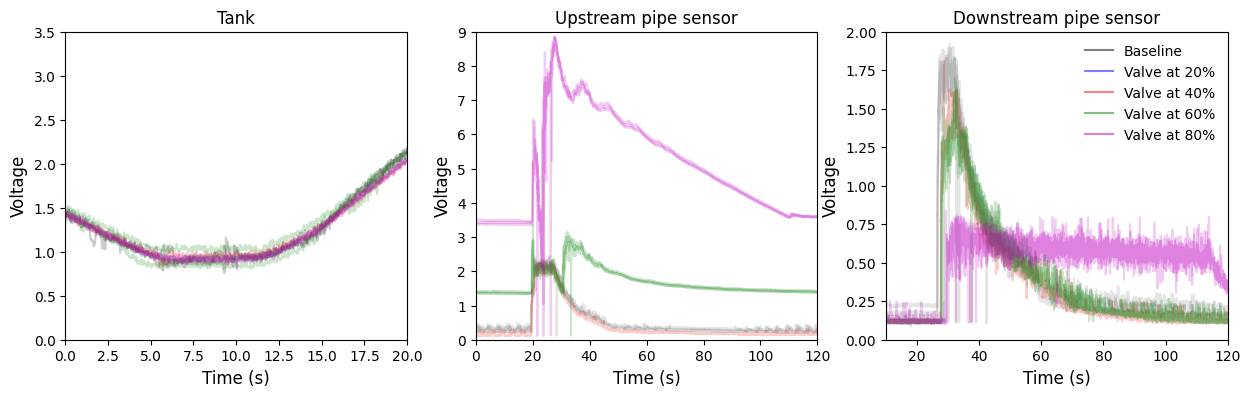

In [18]:
# Unaligned impulse and depth measurements.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# Impulse.
for df in baseline_dfs:
    ax1.plot(df['time'], df['V_ai2'], 'k', alpha=0.2)

for df in test_files_20:
    ax1.plot(df['time'], df['V_ai2'], 'b', alpha=0.4)

for df in test_files_40:
    ax1.plot(df['time'], df['V_ai2'], 'r', alpha=0.2)

for df in test_files_60:
    ax1.plot(df['time'], df['V_ai2'], 'g', alpha=0.2, linestyle='-')

for df in test_files_80:
    ax1.plot(df['time'], df['V_ai2'], 'm', alpha=0.2, linestyle='-')

ax1.set_xlim(0, 20)
ax1.set_ylim(0, 3.5)
ax1.set_title('Tank')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Voltage', fontsize=12)

# Depth in pipe at ai0
for df in baseline_dfs:
    ax2.plot(df['time'], df['V_ai0'], 'k', alpha=0.1)

for df in test_files_20:
    ax2.plot(df['time'], df['V_ai0'], 'b', alpha=0.2)

for df in test_files_40:
    ax2.plot(df['time'], df['V_ai0'], 'r', alpha=0.2)

for df in test_files_60:
    ax2.plot(df['time'], df['V_ai0'], 'g', alpha=0.2, linestyle='-')

for df in test_files_80:
    ax2.plot(df['time'], df['V_ai0'], 'm', alpha=0.2, linestyle='-')

ax2.set_xlim(0, 120)
ax2.set_ylim(0, 9)
ax2.set_title('Upstream pipe sensor')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Voltage', fontsize=12)

# Depth in pipe at ai1.
for df in baseline_dfs:
    ax3.plot(df['time'], df['V_ai1'], 'k', alpha=0.1)

for df in test_files_20:
    ax3.plot(df['time'], df['V_ai1'], 'b', alpha=0.2)

for df in test_files_40:
    ax3.plot(df['time'], df['V_ai1'], 'r', alpha=0.2)

for df in test_files_60:
    ax3.plot(df['time'], df['V_ai1'], 'g', alpha=0.2, linestyle='-')

for df in test_files_80:
    ax3.plot(df['time'], df['V_ai1'], 'm', alpha=0.2, linestyle='-')

ax3.set_xlim(10, 120)
ax3.set_ylim(0, 2)
ax3.set_title('Downstream pipe sensor')
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Voltage', fontsize=12)

# Legend plots.
ax3.plot([], [], 'k', alpha=0.5, label='Baseline')
ax3.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax3.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax3.plot([], [], 'g', alpha=0.5, label='Valve at 60%')
ax3.plot([], [], 'm', alpha=0.5, label='Valve at 80%', linestyle='-')
ax3.legend(fontsize=10, frameon=False)

## Plot sensors against each other

(0.0, 3.0)

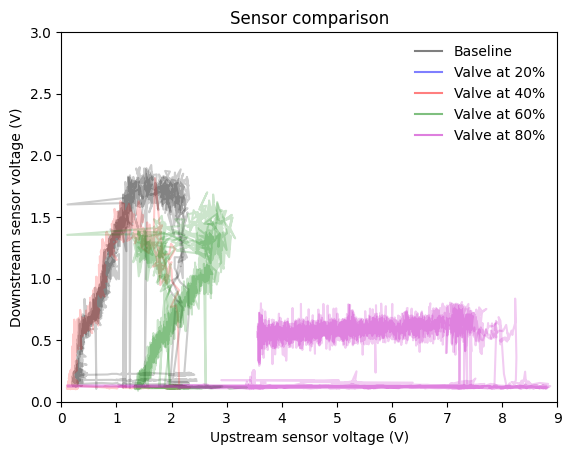

In [21]:
# add averaged stuff

fig, ax = plt.subplots(1,1)

for df in baseline_dfs:
    ax.plot(df['V_ai0'], df['V_ai1'], 'k', alpha=0.2)

for df in test_files_20:
    ax.plot(df['V_ai0'], df['V_ai1'], 'b', alpha=0.2)

for df in test_files_40:
    ax.plot(df['V_ai0'], df['V_ai1'], 'r', alpha=0.2)

for df in test_files_60:
    ax.plot(df['V_ai0'], df['V_ai1'], 'g', alpha=0.2)

for df in test_files_80:
    ax.plot(df['V_ai0'], df['V_ai1'], 'm', alpha=0.2)

ax.set_xlabel('Upstream sensor voltage (V)')
ax.set_ylabel('Downstream sensor voltage (V)')
ax.set_title('Sensor comparison')

ax.plot([], [], 'k', alpha=0.5, label='Baseline')
ax.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax.plot([], [], 'g', alpha=0.5, label='Valve at 60%')
ax.plot([], [], 'm', alpha=0.5, label='Valve at 80%')
ax.legend(fontsize=10, frameon=False)

ax.set_xlim(0,9)
ax.set_ylim(0,3)

## Convert voltages to heights

In [22]:
# Tank measurements.
tank_sensor_name = 'Tank'
b0_tank = sensor_parameters[tank_sensor_name]['calibration']['b0']
b1_tank = sensor_parameters[tank_sensor_name]['calibration']['b1']

# Sergei measurements.
sergei_name = 'Sergei'
b0_sergei = sensor_parameters[sergei_name]['calibration']['b0']
b1_sergei = sensor_parameters[sergei_name]['calibration']['b1']

# Louise measurements.
louise_name = 'Louise'
b0_louise = sensor_parameters[louise_name]['calibration']['b0']
b1_louise = sensor_parameters[louise_name]['calibration']['b1']


# Baseline data frames.
for df in baseline_dfs:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()
    V_sergei = df['V_ai0'].to_numpy()
    V_louise = df['V_ai1'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)
    h_sergei = voltage_to_value(V_sergei, b0_sergei, b1_sergei)
    h_louise = voltage_to_value(V_louise, b0_louise, b1_louise)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank
    df['V_ai0_h'] = h_sergei
    df['V_ai1_h'] = h_louise

# Test data frames.
for df in test_files_20:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()
    V_sergei = df['V_ai0'].to_numpy()
    V_louise = df['V_ai1'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)
    h_sergei = voltage_to_value(V_sergei, b0_sergei, b1_sergei)
    h_louise = voltage_to_value(V_louise, b0_louise, b1_louise)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank
    df['V_ai0_h'] = h_sergei
    df['V_ai1_h'] = h_louise

for df in test_files_40:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()
    V_sergei = df['V_ai0'].to_numpy()
    V_louise = df['V_ai1'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)
    h_sergei = voltage_to_value(V_sergei, b0_sergei, b1_sergei)
    h_louise = voltage_to_value(V_louise, b0_louise, b1_louise)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank
    df['V_ai0_h'] = h_sergei
    df['V_ai1_h'] = h_louise

for df in test_files_60:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()
    V_sergei = df['V_ai0'].to_numpy()
    V_louise = df['V_ai1'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)
    h_sergei = voltage_to_value(V_sergei, b0_sergei, b1_sergei)
    h_louise = voltage_to_value(V_louise, b0_louise, b1_louise)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank
    df['V_ai0_h'] = h_sergei
    df['V_ai1_h'] = h_louise

for df in test_files_80:
    # Tank voltage.
    V_tank = df['V_ai2'].to_numpy()
    V_sergei = df['V_ai0'].to_numpy()
    V_louise = df['V_ai1'].to_numpy()

    # Tank height (cm).
    h_tank = voltage_to_value(V_tank, b0_tank, b1_tank)
    h_sergei = voltage_to_value(V_sergei, b0_sergei, b1_sergei)
    h_louise = voltage_to_value(V_louise, b0_louise, b1_louise)

    # Add new column to df with converted values.
    df['V_ai2_h'] = h_tank
    df['V_ai0_h'] = h_sergei
    df['V_ai1_h'] = h_louise

## Find height derivatives

In [23]:
# Baseline data frames.
for df in baseline_dfs:
    # get height values.
    t = df['time'].to_numpy()
    h_sergei = df['V_ai0_h'].to_numpy()
    h_louise = df['V_ai1_h'].to_numpy()

    # derivatives. 
    dhdt_sergei = approx_dVdt(t, h_sergei)
    dhdt_louise = approx_dVdt(t, h_louise)

    # Add new column to df with converted values.
    df['ai0_dhdt'] = dhdt_sergei
    df['ai1_dhdt'] = dhdt_louise

# Test data frames.
for df in test_files_20:
    # get height values.
    t = df['time'].to_numpy()
    h_sergei = df['V_ai0_h'].to_numpy()
    h_louise = df['V_ai1_h'].to_numpy()

    # derivatives. 
    dhdt_sergei = approx_dVdt(t, h_sergei)
    dhdt_louise = approx_dVdt(t, h_louise)

    # Add new column to df with converted values.
    df['ai0_dhdt'] = dhdt_sergei
    df['ai1_dhdt'] = dhdt_louise

for df in test_files_40:
    # get height values.
    t = df['time'].to_numpy()
    h_sergei = df['V_ai0_h'].to_numpy()
    h_louise = df['V_ai1_h'].to_numpy()

    # derivatives. 
    dhdt_sergei = approx_dVdt(t, h_sergei)
    dhdt_louise = approx_dVdt(t, h_louise)

    # Add new column to df with converted values.
    df['ai0_dhdt'] = dhdt_sergei
    df['ai1_dhdt'] = dhdt_louise

for df in test_files_60:
    # get height values.
    t = df['time'].to_numpy()
    h_sergei = df['V_ai0_h'].to_numpy()
    h_louise = df['V_ai1_h'].to_numpy()

    # derivatives. 
    dhdt_sergei = approx_dVdt(t, h_sergei)
    dhdt_louise = approx_dVdt(t, h_louise)

    # Add new column to df with converted values.
    df['ai0_dhdt'] = dhdt_sergei
    df['ai1_dhdt'] = dhdt_louise

for df in test_files_80:
    # get height values.
    t = df['time'].to_numpy()
    h_sergei = df['V_ai0_h'].to_numpy()
    h_louise = df['V_ai1_h'].to_numpy()

    # derivatives. 
    dhdt_sergei = approx_dVdt(t, h_sergei)
    dhdt_louise = approx_dVdt(t, h_louise)

    # Add new column to df with converted values.
    df['ai0_dhdt'] = dhdt_sergei
    df['ai1_dhdt'] = dhdt_louise

## Plot dh/dt over time

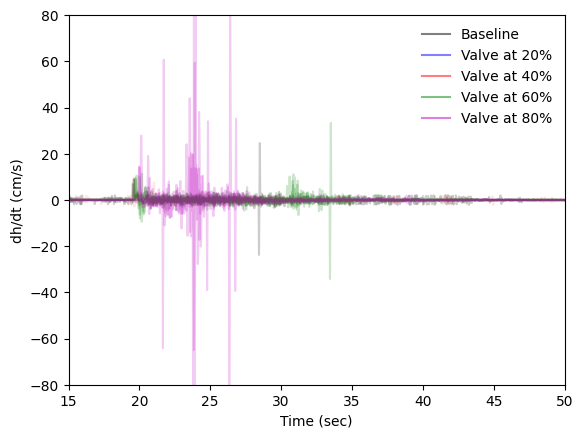

In [28]:
fig, ax = plt.subplots(1, 1)

for df in baseline_dfs:
    ax.plot(df['time'], df['ai0_dhdt'], 'k', alpha=0.2)

for df in test_files_20:
    ax.plot(df['time'], df['ai0_dhdt'], 'b', alpha=0.1)

for df in test_files_40:
    ax.plot(df['time'], df['ai0_dhdt'], 'r', alpha=0.1)

for df in test_files_60:
    ax.plot(df['time'], df['ai0_dhdt'], 'g', alpha=0.2)

for df in test_files_80:
    ax.plot(df['time'], df['ai0_dhdt'], 'm', alpha=0.2)

ax.set_xlim(15, 50)
ax.set_ylim(-80, 80)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('dh/dt (cm/s)')

# legend
ax.plot([], [], 'k', alpha=0.5, label='Baseline')
ax.plot([], [], 'b', alpha=0.5, label='Valve at 20%')
ax.plot([], [], 'r', alpha=0.5, label='Valve at 40%')
ax.plot([], [], 'g', alpha=0.5, label='Valve at 60%')
ax.plot([], [], 'm', alpha=0.5, label='Valve at 80%')
ax.legend(fontsize=10, frameon=False)